In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

from langdetect import detect
import re

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

## GET DATA

In [8]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [9]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [10]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '337627',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/6ixWMkMQQFz7WMlLT0aHWg__thumb/img/lbE0fqB5FHozp8g9ggzSYcLQPgo=/fit-in/200x150/filters:strip_icc()/pic6153215.jpg',
  'name': 'Voidfall',
  'yearpublished': '2022'},
 {'id': '316624',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/eUiju5SqZbkNt8gnEofrTw__thumb/img/zNkmLNyeXJGOY24FeAAf4U67ejU=/fit-in/200x150/filters:strip_icc()/pic6035127.png',
  'name': 'Stationfall',
  'yearpublished': '2021'}]

In [11]:
try:
    comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

<ipython-input-11-3c366f14faf3>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")


reading dataframe from csv file...


,id,username,rating,value
0,337627,BGFreakDag2PT,N/A,On Radar
1,337627,Bstalf21,N/A,KS fall?
2,337627,bucklen_uk,N/A,I don't rate my own games (doesn't seem approp...
3,337627,carlcorey,N/A,"Turczi / Mindclash with O'Toole design, intere..."
4,337627,Dark Herald,N/A,Notes: To Consider
...,...,...,...,...
85786,167791,z_zadar,9.0,Some games are so much fun. Others can be a li...
85787,167791,_Czid_,8.0,Have played with Elysium and Prelude expansion...
85788,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
85789,167791,_mun_,10.0,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [12]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [13]:
comments_df["value"] = comments_df["value"].astype(str)

In [14]:
# REMOVE URLs FROM COMMENTS

In [15]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [16]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [17]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 14425 for 'remove_short_comments' - min len: 25 - method: unrated


In [18]:
# REMOVE NON ENGLISH COMMENTS

In [19]:
# !conda install -c conda-forge langdetect

In [20]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [21]:
# comments_df = add_comments_lang(comments_df)

In [22]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [23]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10.0      13949
9.0       13485
8.0       11399
7.0        6225
N/A        5932
          ...  
9.013         1
9.21          1
5.67          1
9.924         1
8.5462        1
Name: rating, Length: 500, dtype: int64

In [24]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(65434, 5)

In [25]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(5932, 5)

## CREATE TRAINING AND VALIDATION DATA

In [26]:
# use rated comments (reviews) to train the model

In [27]:
rated_comments = rated_comments.sample(frac=1)

In [28]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [29]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


"POSITIVES - Great Rulebook, simple rules that you can teach within 5-10 minutes. - AMAZING DEPTH. The feeling of getting your plan ready by the fourth round but sometimes shying short of 1 or 2 resource cubes has that satisfying feel of frustration. - AMAZING ART.  - QUICK GAMES that lasts no more than 30-40 minutes.  Negatives - Needs MULTIPLE plays to get a feel for the game. I've seen a lot of people sell this game after 1 play which is an absolute shame as the game really shines after 4-5 plays. - Might have a THEMATIC disconnect to some people. - While the BASE GAME is great, I wouldn't recommend buying this game without the KICKSTARTER exclusives.  Final Thoughts: A DEEPER, more brain burning puzzle than 7 Wonders. A lot of my friends thought this game was a 7W knock off and it may seem like that in the first play or two. But as you play the game more you'll find out they're nothing alike. "

In [30]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'If a game is a series of interesting and consequential decisions, On Mars succeeds.  On the plus side, it\'s fairly interactive - that people are competing together where everything other players do may impact what works best for you is a pretty neat thing.  The game throws a lot of hurdles in the way; getting anything done efficiently is an exercise in planning, calculation, and a dash of pressing you luck.  On the downside, it feels like it\'s the game\'s goal to say "No, you can\'t do that just yet!". Pretty much continuously.'

In [31]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [32]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 8.71176064e-01,  1.76093459e-01,  6.18864223e-03,
         6.54391348e-01, -2.32303012e-02, -2.95081198e-01,
         8.05821791e-02,  3.40628892e-01, -6.65079355e-01,
         4.68711644e-01,  2.51830101e-01,  3.77998769e-01,
        -3.62003371e-02,  2.08470911e-01, -8.39158818e-02,
        -3.22589546e-01, -4.02029365e-01,  2.46331125e-01,
         2.07211778e-01, -7.04945385e-01, -1.73197672e-01,
        -9.68799740e-02,  5.94641149e-01,  2.01063484e-01,
        -1.46191180e-01, -9.23446715e-02, -1.23009646e+00,
         3.17142308e-01,  8.02647769e-02, -5.49152255e-01,
        -5.55751026e-01,  4.25433032e-02,  1.94674894e-01,
        -5.11649907e-01,  1.17097981e-01,  3.60439420e-01,
         2.44238287e-01, -1.55843407e-01,  5.29157996e-01,
        -1.23889089e+00,  1.02452822e-01,  1.76642492e-01,
        -9.48969573e-02,  8.36259220e-03, -3.17394093e-04,
        -5.39035648e-02, -3.15435439e-01, -1.69487432e-01,
       

In [33]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [35]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Epoch 1/40
96/96 - 7s - loss: 0.4899 - accuracy: 0.8281 - val_loss: 0.3822 - val_accuracy: 0.8592
Epoch 2/40
96/96 - 5s - loss: 0.3296 - accuracy: 0.8721 - val_loss: 0.3147 - val_accuracy: 0.8785
Epoch 3/40
96/96 - 5s - loss: 0.2686 - accuracy: 0.8944 - val_loss: 0.2998 - val_accuracy: 0.8833
Epoch 4/40
96/96 - 5s - loss: 0.2309 - accuracy: 0.9094 - val_loss: 0.3008 - val_accuracy: 0.8834
Epoch 5/40
96/96 - 5s - loss: 0.2032 - accuracy: 0.9220 - val_loss: 0.3109 - val_accuracy: 0.8798
Epoch 6/40
96/96 - 5s - loss: 0.1809 - accuracy: 0.9315 - val_loss: 0.3268 - val_accuracy: 0.8774
Epoch 7/40
96/96 - 5s - loss: 0.1627 - accuracy: 0.9404 - val_loss: 0.3467 - val_accuracy: 0.8733
Epoch 8/40
96/96 - 5s - loss: 0.1479 - accuracy: 0.9462 - val_loss: 0.3674 - val_accuracy: 0.8697


In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [38]:
epochs = range(1, len(acc) + 1) 

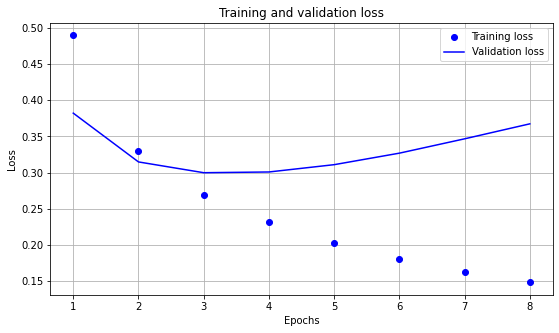

In [39]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

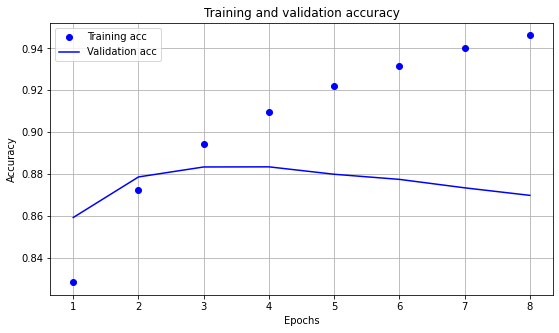

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [41]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [42]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"Amazingly fun co-op RPG with tons of content and surprisingly deep and varied combat. Easily my favourite board game."
score: 0.999999
actual value:1

input:
"I really enjoy the game.  Setup is tedious, and having to juggle multiple campaigns for different gaming groups can be a pain."
score: 0.668128
actual value:1

input:
"Theme is incredible.  One of the best, most immersive table top experiences I have had.  Quality of components is a big upside including a ridiculous level of detail.  While there is a pretty significant amount of luck, I find that the strategy is enough to overcome, or at least mitigate most of it.  This is, in my opinion, the quitensential dungeon crawler that all other measure against, and it has set the bar very high.  Cons include price of entry, setup time, some fiddly rules and exceptions, long play times (which can be seen as a pro), and a pretty steep learning curve.  With multiple plays, the game starts to click, and when it does, this will eat yo

In [43]:
## APPLY MODEL ON NON-RATED COMMENTS

In [44]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Probably my next game. Cool subject and currently #3 (!!!)"
score: 0.996114

input:
"Mayday Chimera Orange P Sleeves"
score: 0.999019

input:
"Sleeved with Arcane Tinmen Non Glare - Standard - 234 cards"
score: 0.999862

input:
"LD. Complex cooperative game with interesting theme. Is it better than Robinson Crusoe? Doesnt feel so +/-"
score: 0.760621

input:
"Its very annoying seeing a bunch of people give a game that hasnt come out a bunch of bad ratings. Especially when someone like jamie has put so much time and care into this project. "
score: 0.428900

input:
"Kickstarter Galactic councelor pledge."
score: 0.990439

input:
"Using "Want to Buy" to keep track of games I'm interested in for 2 Players"
score: 0.998869

input:
"Art Connoisseur Collector's Edition + Invaders from Afar expansion + The Wind Gambit expansion + The Rise of Fenris expansion + Encounters expansion + Metal Coins"
score: 0.997554

input:
"Play this over and over, best with 2 or 3 players though. Otherwi

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [45]:
rated_comments.head()

,id,username,rating,value,comment_len
11307,271324,foonisha,9.0,"POSITIVES - Great Rulebook, simple rules that ...",694
30122,193738,gohrns,7.5,Auction 7/17 Punched.,14
51119,162886,russonc,10.0,"Mainly play solo (2 characters), but enjoy wit...",293
61398,174430,PoppaKrunch,10.0,"The hype is genuinely well deserved, its a bri...",371
65652,167791,Patmol,10.0,A Must Have,9


In [46]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
rated_comments_grouped.head()

,id,rating_mean,rating_count
0,162886,8.350861,3483
1,167355,8.417982,1773
2,167791,8.210249,8205
3,169786,8.100792,7309
4,174430,8.550854,6302


In [47]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [48]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
not_rated_comments_grouped.head()

,id,rating_mean,rating_count
0,162886,8.747712,306
1,167355,9.119718,213
2,167791,8.836009,436
3,169786,8.661395,588
4,174430,8.648592,568


In [67]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'))
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")

In [68]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url
0,337627,NaN,NaN,NaN,NaN,1,https://cf.geekdo-images.com/6ixWMkMQQFz7WMlLT...,Voidfall,2022,https://boardgamegeek.com/boardgame/337627
1,316624,9.307692,13.0,9.728571,7.0,2,https://cf.geekdo-images.com/eUiju5SqZbkNt8gnE...,Stationfall,2021,https://boardgamegeek.com/boardgame/316624
2,312484,7.939504,628.0,8.561905,63.0,3,https://cf.geekdo-images.com/6GqH14TJJhza86BX5...,Lost Ruins of Arnak,2020,https://boardgamegeek.com/boardgame/312484
3,277700,8.507895,38.0,8.969048,42.0,4,https://cf.geekdo-images.com/-JD8JLncWYMes9Q6Y...,Merchants Cove,2021,https://boardgamegeek.com/boardgame/277700
4,318977,7.897923,207.0,8.056250,16.0,5,https://cf.geekdo-images.com/1M-1d6fr3U9t670MC...,MicroMacro: Crime City,2020,https://boardgamegeek.com/boardgame/318977


In [69]:
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) / (grouped['rating_count_review']+grouped['rating_count_comments'])

In [70]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url,fixed_rating
0,337627,NaN,NaN,NaN,NaN,1,https://cf.geekdo-images.com/6ixWMkMQQFz7WMlLT...,Voidfall,2022,https://boardgamegeek.com/boardgame/337627,NaN
1,316624,9.307692,13.0,9.728571,7.0,2,https://cf.geekdo-images.com/eUiju5SqZbkNt8gnE...,Stationfall,2021,https://boardgamegeek.com/boardgame/316624,9.455000
2,312484,7.939504,628.0,8.561905,63.0,3,https://cf.geekdo-images.com/6GqH14TJJhza86BX5...,Lost Ruins of Arnak,2020,https://boardgamegeek.com/boardgame/312484,7.996250
3,277700,8.507895,38.0,8.969048,42.0,4,https://cf.geekdo-images.com/-JD8JLncWYMes9Q6Y...,Merchants Cove,2021,https://boardgamegeek.com/boardgame/277700,8.750000
4,318977,7.897923,207.0,8.056250,16.0,5,https://cf.geekdo-images.com/1M-1d6fr3U9t670MC...,MicroMacro: Crime City,2020,https://boardgamegeek.com/boardgame/318977,7.909283


In [71]:
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')

In [72]:
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

In [73]:
grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [74]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [75]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,NaN,NaN,NaN,1,2022
2,,Stationfall,9.307692,9.728571,9.455000,2,2021
3,,Lost Ruins of Arnak,7.939504,8.561905,7.996250,3,2020
4,,Merchants Cove,8.507895,8.969048,8.750000,4,2021
5,,MicroMacro: Crime City,7.897923,8.056250,7.909283,5,2020


In [76]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,ICE,9.750000,8.750000,9.416667,31,2022
2,,Stationfall,9.307692,9.728571,9.455000,2,2021
3,,Eclipse: Second Dawn for the Galaxy,8.732574,8.684524,8.724721,43,2020
4,,Kemet: Blood and Sand,8.700000,8.701818,8.701250,44,2021
5,,Brass: Birmingham,8.691188,8.987879,8.718801,30,2018


In [77]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Stationfall,9.307692,9.728571,9.455000,2,2021
2,,ICE,9.750000,8.750000,9.416667,31,2022
3,,Merchants Cove,8.507895,8.969048,8.750000,4,2021
4,,Eclipse: Second Dawn for the Galaxy,8.732574,8.684524,8.724721,43,2020
5,,Brass: Birmingham,8.691188,8.987879,8.718801,30,2018


In [60]:
# model.save('saved_model\my_model')

In [61]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [62]:
# some examples on "long" comments vs short comments

In [63]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()

In [64]:
# some long comments
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results, limit=25)

input:
"Need to play more but so far I love the theme, art and little bird facts on the cards. The mechanics are smooth and as far as engine building goes it seems to be a big step up from something like Splendor."
score: 0.836213

input:
"Soloable: Have Steam App.  Beyond high rating, it supposedly plays solo very well, so add to short-list."
score: 0.998872

input:
"'Civ' type game. 4x: "explore, expand, exploit, and exterminate".  Play for strategic thinking of how to win over your opponents in political and economical decisions.  Typically played in 2-3hr sessions."
score: 0.854677

input:
"Check it out (Monique and Naveen have a playthrough). Cards played through the game do things for you, but also the cards you have at the end matter, getting combinations and interactions between them. I think."
score: 0.789940

input:
"I supported the game during the KickStarter campaign, and my name now is written on the personal copy of Isaac Childres. I have had the opportunity to talk with 